In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load the dataset

hotmusic_df = pd.read_csv('Hot_Stuff.csv')
hot_audio_feature_df = pd.read_excel('Hot_100_Audio_Features.xlsx')
billaboard_df = pd.read_csv('billboard.csv')
audio_feature_df = pd.read_csv('audio_features.csv')


#billaboard_df.head(5)
#audio_feature_df.head(5)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhakt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Task2 EDA

There are 327895 rows and 10 columns
url
WeekID
Week Position
Song
Performer
SongID
Instance
Previous Week Position
Peak Position
Weeks on Chart
There are 29503 rows and 22 columns in hot_audio_feature_df
SongID
Performer
Song
spotify_genre
spotify_track_id
spotify_track_preview_url
spotify_track_duration_ms
spotify_track_explicit
spotify_track_album
danceability
energy
key
loudness
mode
speechiness
acousticness
instrumentalness
liveness
valence
tempo
time_signature
spotify_track_popularity


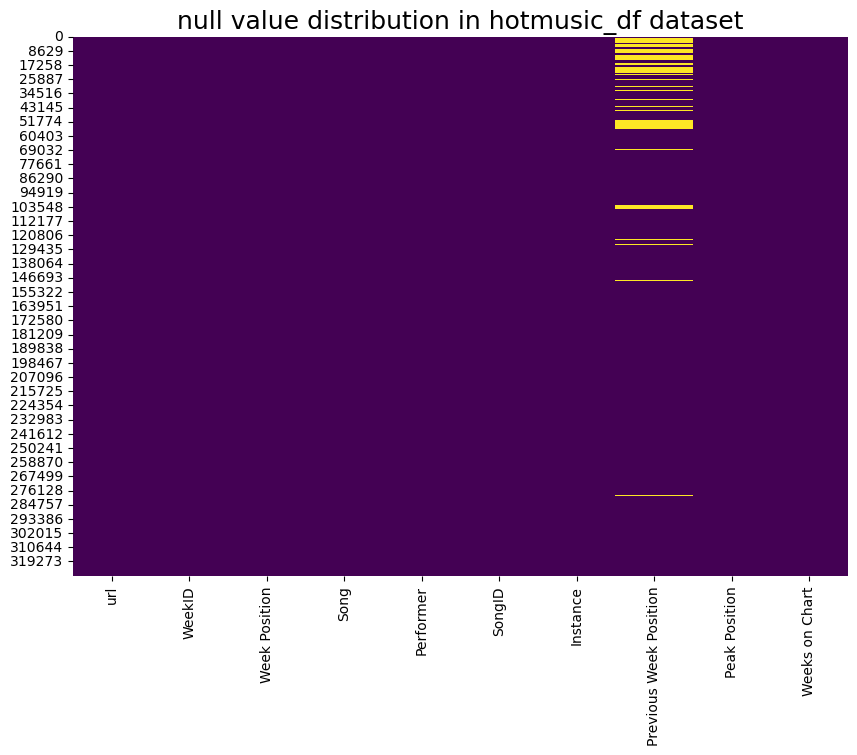

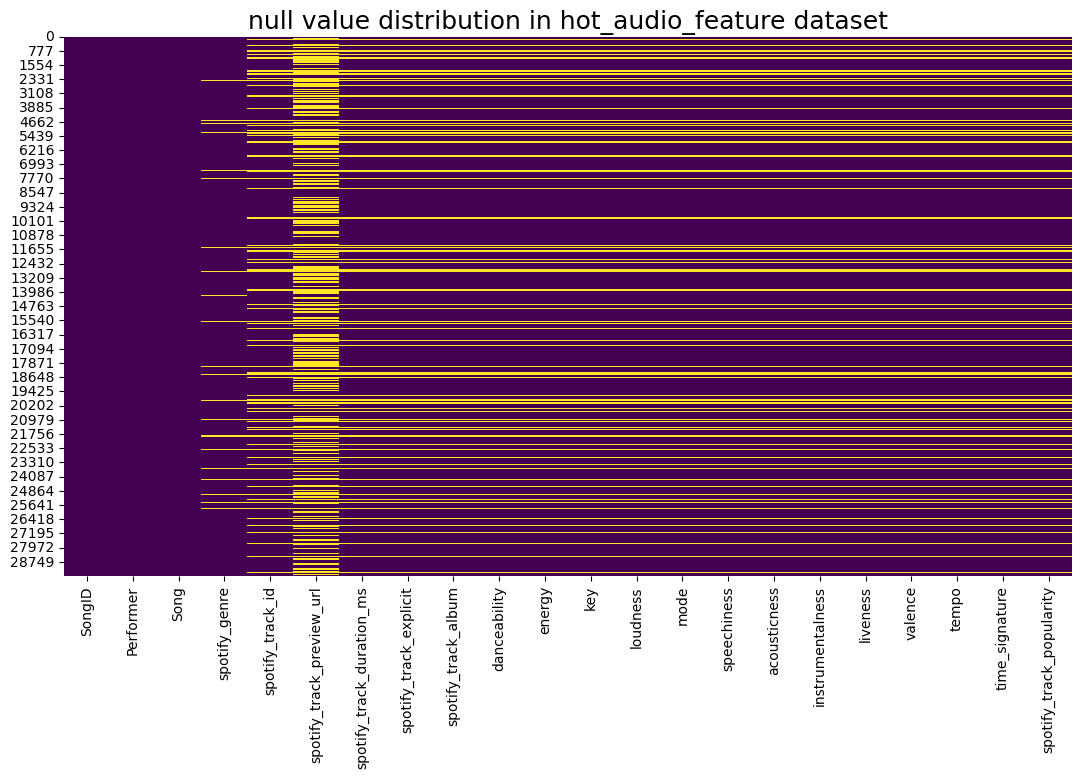

There are 327895 rows and 10 columns in billaboard_df
url
week_id
week_position
song
performer
song_id
instance
previous_week_position
peak_position
weeks_on_chart


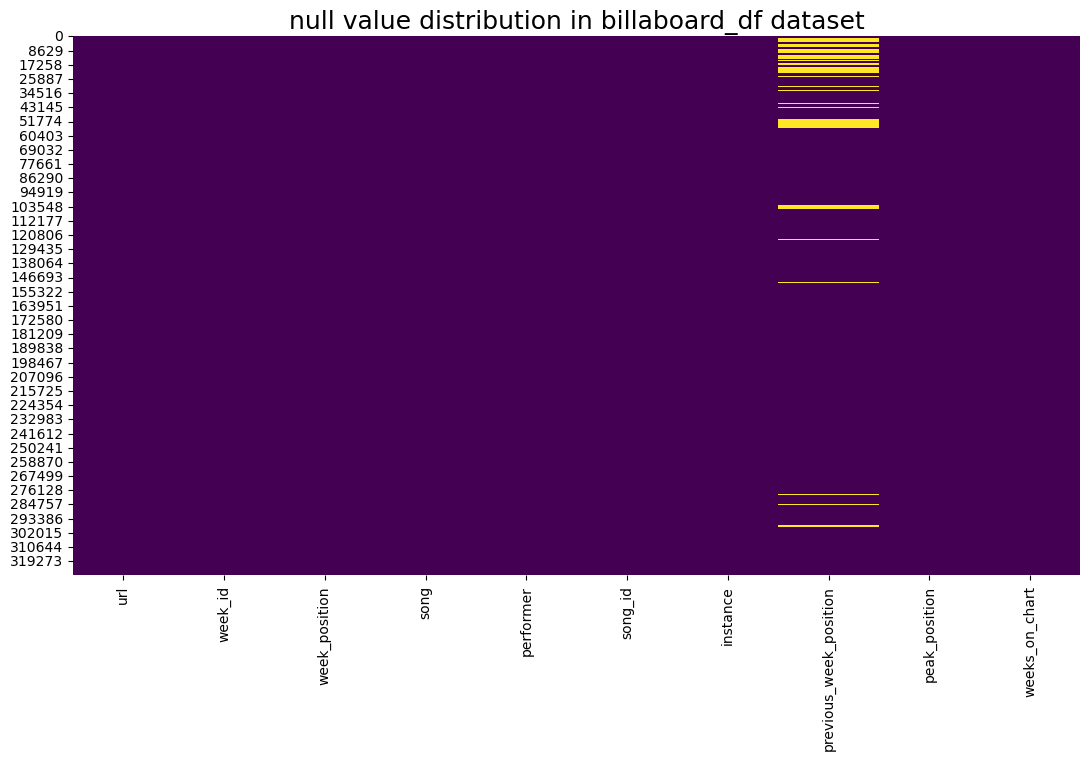

There are 29503 rows and 22 columns in audio_feature_df
song_id
performer
song
spotify_genre
spotify_track_id
spotify_track_preview_url
spotify_track_duration_ms
spotify_track_explicit
spotify_track_album
danceability
energy
key
loudness
mode
speechiness
acousticness
instrumentalness
liveness
valence
tempo
time_signature
spotify_track_popularity


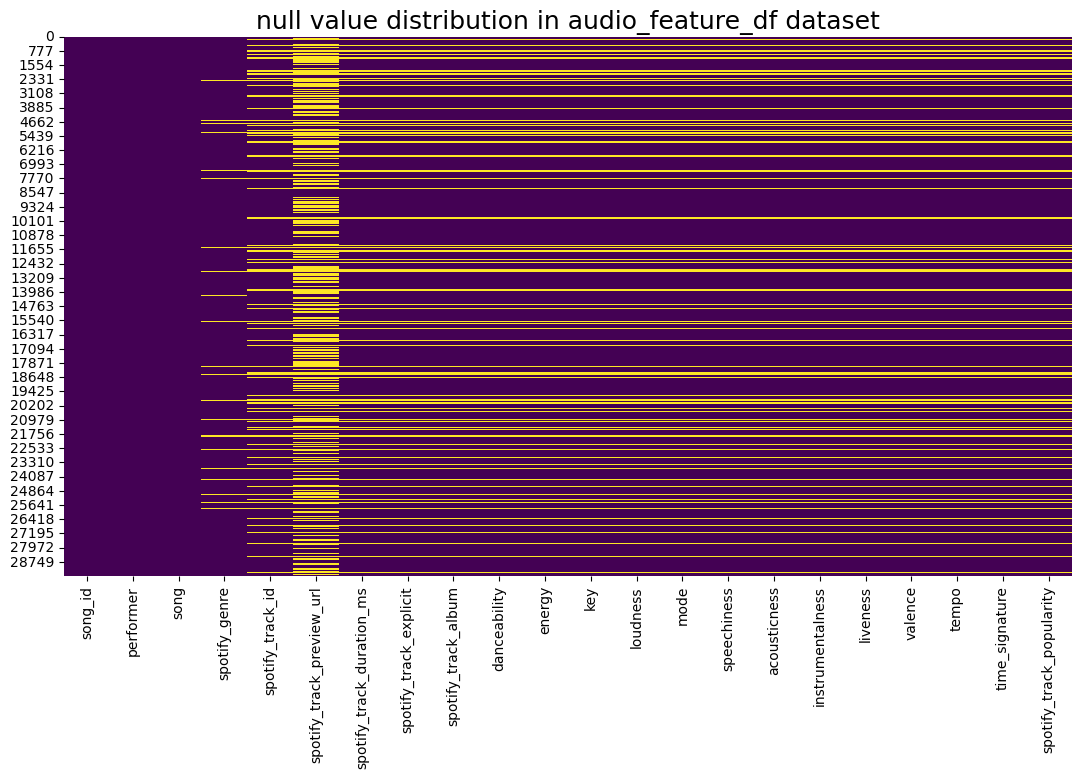

In [4]:
# EDA 1: know the data and column in datasets
#1)  rows and columns information from hotmusic_df
hotmusic_df_nRow, hotmusic_df_nCol = hotmusic_df.shape
print(f'There are {hotmusic_df_nRow} rows and {hotmusic_df_nCol} columns')

for col in hotmusic_df.columns:
    print(col)
# rename columns in hotmusic_df
hotmusic_df.rename(columns={'Week Position': 'Week_Position', 'Previous Week Position': 'Previous_Week_Position', 'Peak Position': 'Peak_Position','Weeks on Chart':'Weeks_on_Chart'})
hotmusic_df.isnull().sum()  

# Visualizing the Missing Values in hotmusic_df
fig, ax = plt.subplots(figsize=(10,7))
title = "null value distribution in hotmusic_df dataset"

plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])
sns.heatmap(hotmusic_df.isnull(),cbar=False,cmap='viridis')

#2)rows and columns information from hot_audio_feature_df
hot_audio_feature_df_nRow, hot_audio_feature_df_nCol = hot_audio_feature_df.shape
print(f'There are {hot_audio_feature_df_nRow} rows and {hot_audio_feature_df_nCol} columns in hot_audio_feature_df')

for col in hot_audio_feature_df.columns:
    print(col)
hot_audio_feature_df.isnull().sum()  

# Visualizing the Missing Values in hot_audio_feature_df
fig, ax = plt.subplots(figsize=(13,7))
title = "null value distribution in hot_audio_feature dataset"


plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

sns.heatmap(hot_audio_feature_df.isnull(),cbar=False,cmap='viridis')
plt.show()

#3)rows and columns information from billaboard_df
billaboard_df_nRow, billaboard_df_nCol = billaboard_df.shape
print(f'There are {billaboard_df_nRow} rows and {billaboard_df_nCol} columns in billaboard_df')

for col in billaboard_df.columns:
    print(col)
billaboard_df.isnull().sum()  

# Visualizing the Missing Values in billaboard_df
fig, ax = plt.subplots(figsize=(13,7))
title = "null value distribution in billaboard_df dataset"


plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

sns.heatmap(billaboard_df.isnull(),cbar=False,cmap='viridis')
plt.show()

#4)rows and columns information from audio_feature_df
audio_feature_df_nRow, audio_feature_df_nCol = audio_feature_df.shape
print(f'There are {audio_feature_df_nRow} rows and {audio_feature_df_nCol} columns in audio_feature_df')

for col in audio_feature_df.columns:
    print(col)
audio_feature_df.isnull().sum()  

# Visualizing the Missing Values in billaboard_df
fig, ax = plt.subplots(figsize=(13,7))
title = "null value distribution in audio_feature_df dataset"


plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

sns.heatmap(audio_feature_df.isnull(),cbar=False,cmap='viridis')
plt.show()


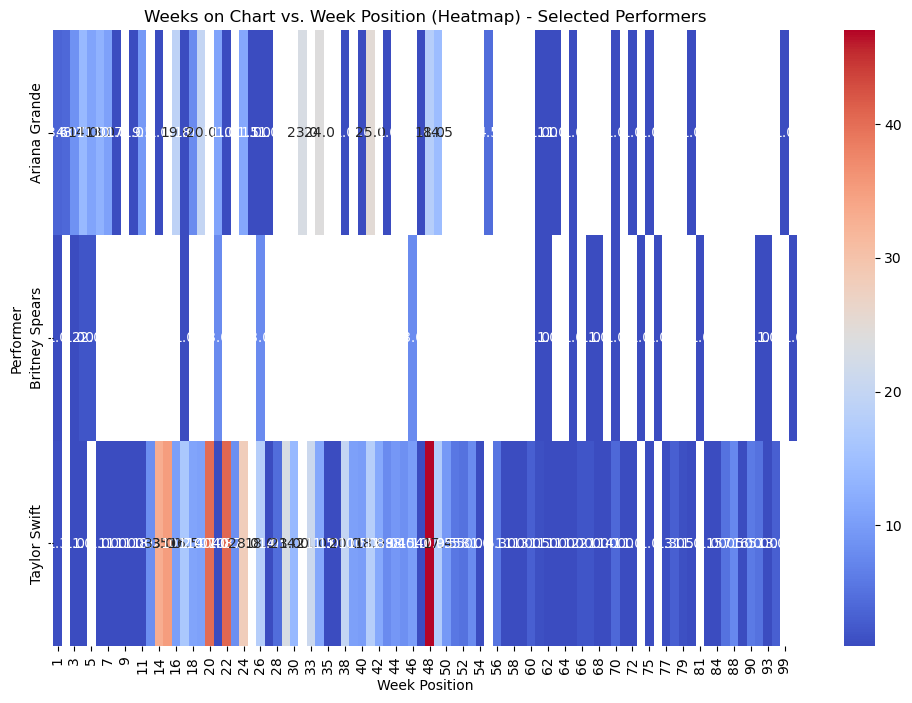

In [4]:
# 1 EDA Weeks on Chart vs. Week Position (Heatmap) - Selected Performers

cols_to_use = audio_feature_df.columns.difference(billaboard_df.columns)
# Join the two DataFrames on the 'song_id' column
df = pd.merge(billaboard_df, audio_feature_df[cols_to_use], left_index=True, right_index=True, how='inner')

# Define the list of performers to include
performerlist = ['Taylor Swift', 'Britney Spears', 'Ariana Grande']

# Filter the DataFrame to include only data for the selected performers
filtered_df = df[df['performer'].isin(performerlist)].copy() 

filtered_df.loc[:, 'weeks_on_chart'] = pd.to_numeric(filtered_df['weeks_on_chart'], errors='coerce')  # Use .loc to modify the original DataFrame
filtered_df.loc[:, 'week_position'] = pd.to_numeric(filtered_df['week_position'], errors='coerce')

heatmap_data = filtered_df.pivot_table(index='performer', columns='week_position', values='weeks_on_chart', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar=True, annot=True, fmt=".1f")
plt.title('Weeks on Chart vs. Week Position (Heatmap) - Selected Performers')
plt.xlabel('Week Position')
plt.ylabel('Performer')
plt.show()



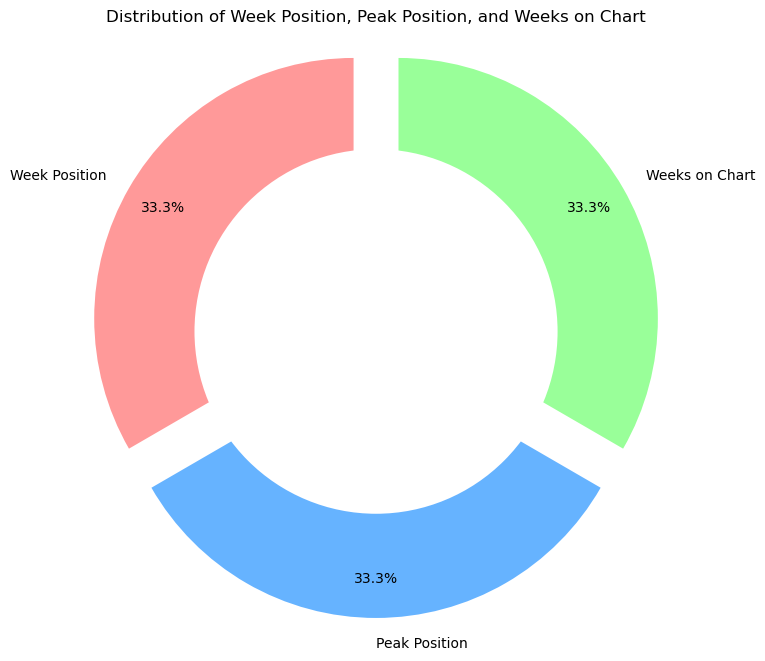

In [5]:
# 2 EDA

# header = billaboard_df.columns.tolist()
# print(header)

# Group the data by 'Week Position', 'Peak Position', and 'Weeks on Chart'
grouped_data = billaboard_df.groupby(['week_position', 'peak_position', 'weeks_on_chart']).size().reset_index(name='count')

# Calculate the total count for all data points
total_count = grouped_data['count'].sum()

# Create a pie chart
labels = ['Week Position', 'Peak Position', 'Weeks on Chart']
sizes = [grouped_data['count'].sum() for _ in labels]
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.1, 0.1, 0.1)  # Explode the 1st slice (Week Position)

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.title('Distribution of Week Position, Peak Position, and Weeks on Chart')
plt.show()



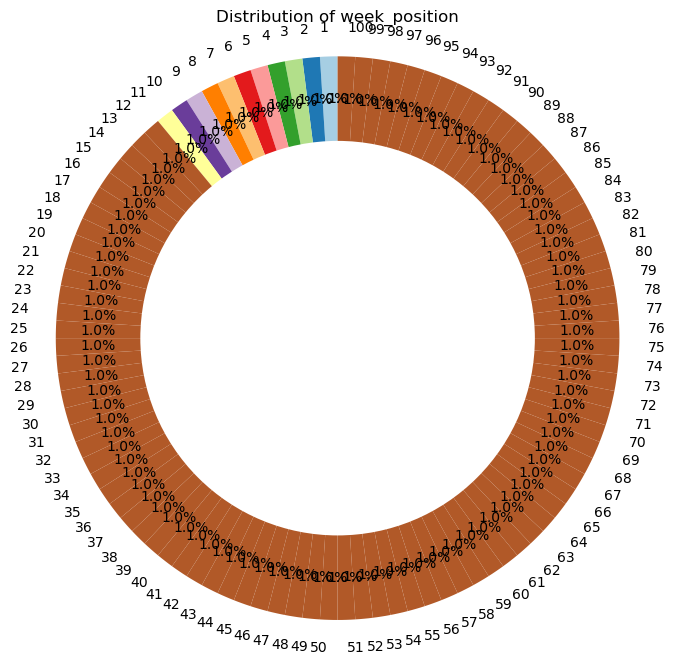

In [6]:
# Columns to consider for EDA and pie chart
columns_to_group = ['week_position']

# Group the data by the specified columns and calculate the count of each group
grouped_data = billaboard_df.groupby(columns_to_group).size().reset_index(name='count')

# Create a pie chart for each grouped column
for column in columns_to_group:
    labels = grouped_data[column]
    sizes = grouped_data['count']
    colors = plt.cm.Paired(range(len(labels)))

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.axis('equal')
    plt.title(f'Distribution of {column}')
    plt.show()

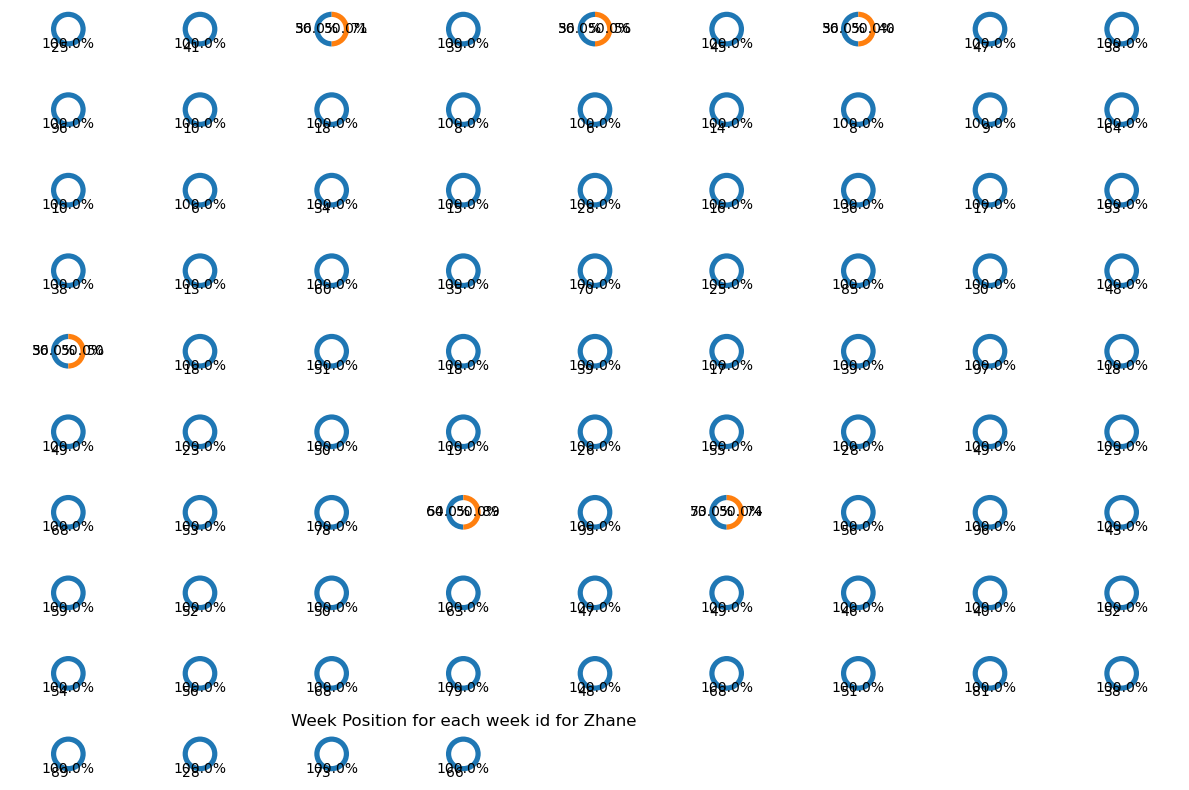

In [7]:
# Filter the DataFrame to include only data for the performer 'Zhane'
zhane_df = billaboard_df[billaboard_df['performer'] == 'Zhane']

# Group the data by 'WeekID' and 'week_position' and calculate the count of each group
grouped_data = zhane_df.groupby(['week_id', 'week_position']).size().reset_index(name='count')

# Get unique 'WeekID' values
unique_week_ids = grouped_data['week_id'].unique()

# Calculate the number of rows and columns for subplots based on the number of 'WeekID' values
num_week_ids = len(unique_week_ids)
num_rows = int(num_week_ids ** 0.5) + 1
num_cols = (num_week_ids + num_rows - 1) // num_rows

# Create subplots
plt.figure(figsize=(12, 8))

for i, week_id in enumerate(unique_week_ids):
    data_for_week_id = grouped_data[grouped_data['week_id'] == week_id]
    labels = data_for_week_id['week_position']
    sizes = data_for_week_id['count']

    plt.subplot(num_rows, num_cols, i + 1) 
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.axis('equal')
    #plt.title(f'WeekID: {week_id}')


plt.title("Week Position for each week id for Zhane")    
plt.tight_layout()
plt.show()

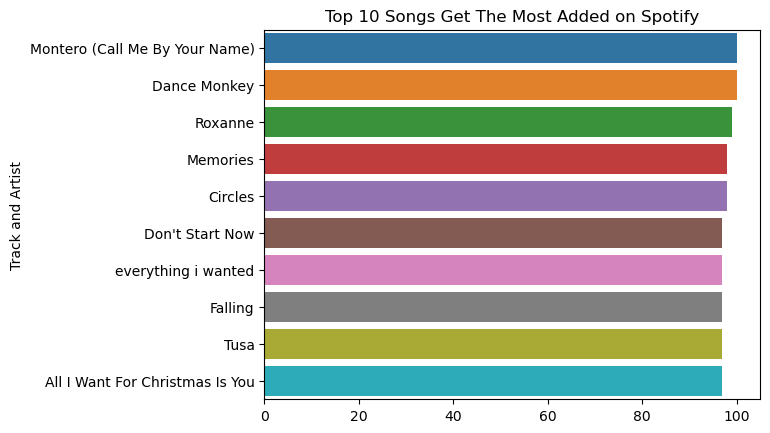

In [8]:
most_added_song_in_spotify = audio_feature_df.groupby("song")["spotify_track_popularity"].max().sort_values(ascending = False).head(10)

sns.barplot(x = most_added_song_in_spotify.values, y = most_added_song_in_spotify.index);
plt.title("Top 10 Songs Get The Most Added on Spotify")
plt.ylabel("Track and Artist")
plt.show()

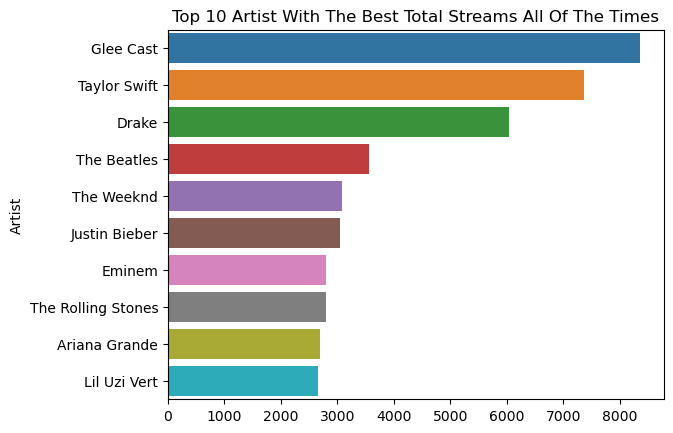

In [9]:
most_stream_artist = audio_feature_df.groupby("performer")["spotify_track_popularity"].sum().sort_values(ascending = False).head(10)

sns.barplot(x = most_stream_artist.values, y = most_stream_artist.index);
plt.title("Top 10 Artist With The Best Total Streams All Of The Times")
plt.ylabel("Artist")
plt.show()

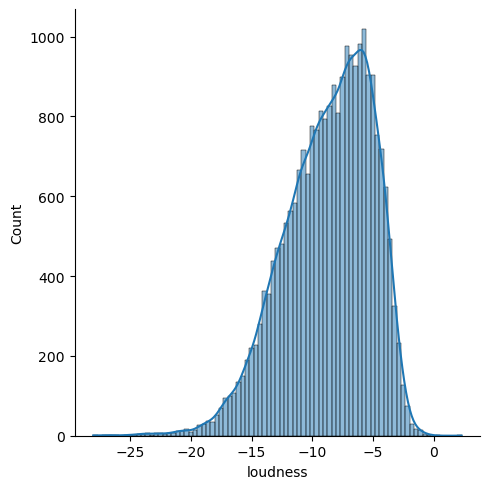

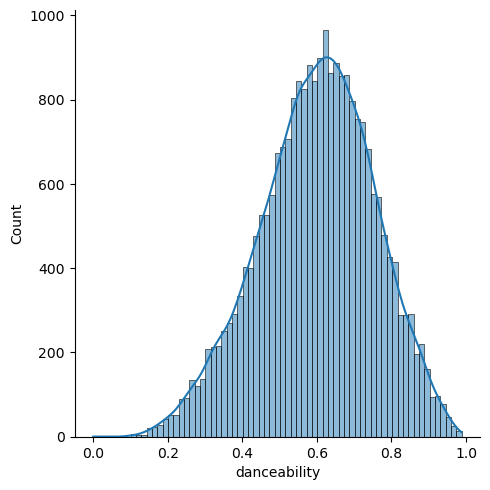

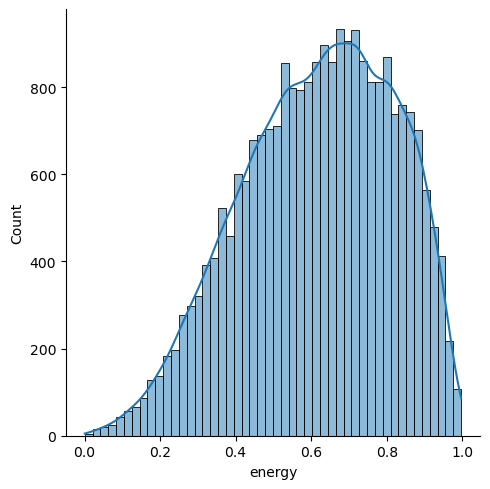

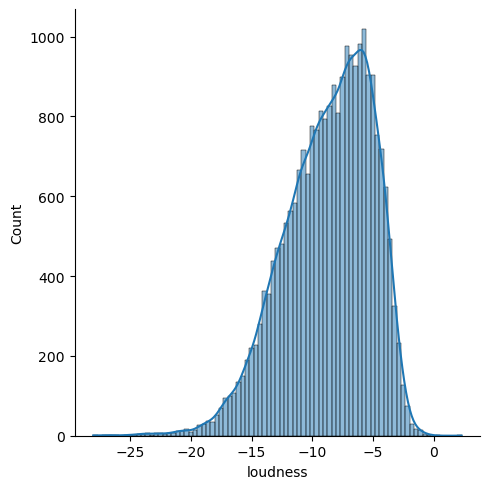

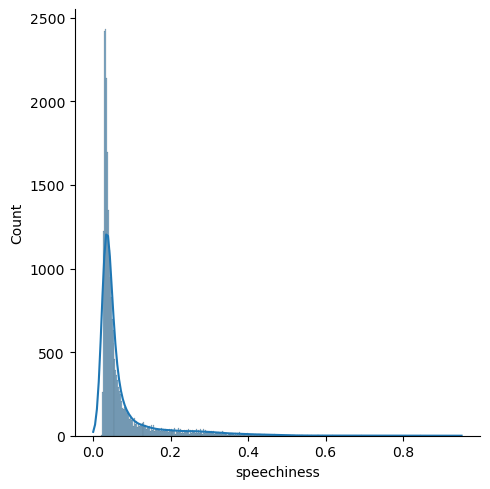

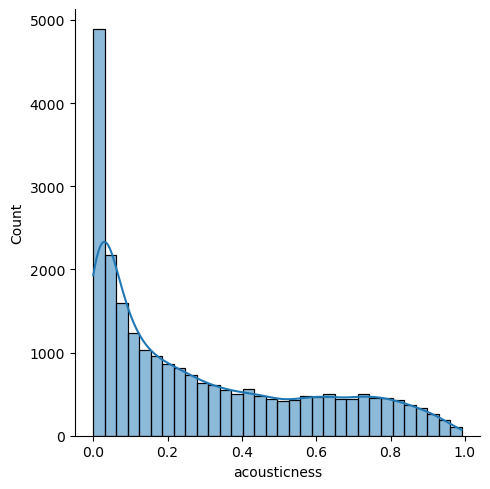

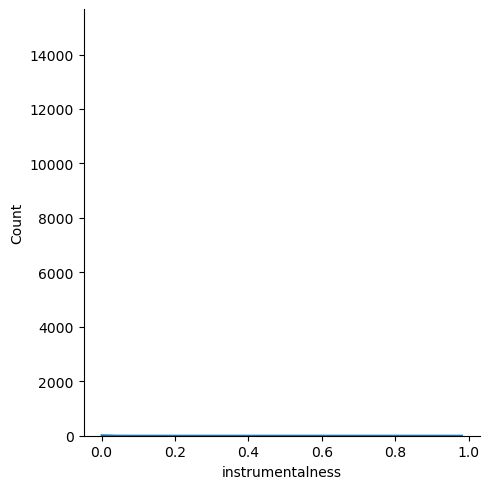

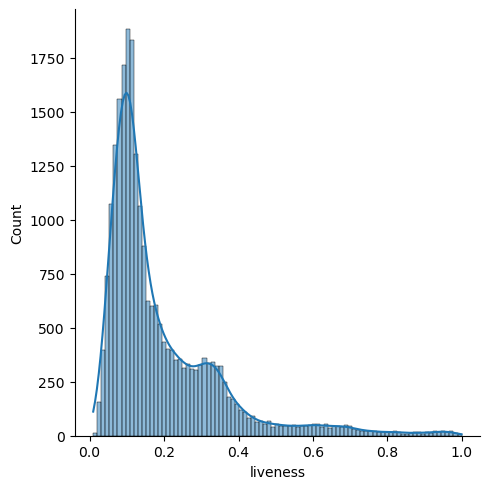

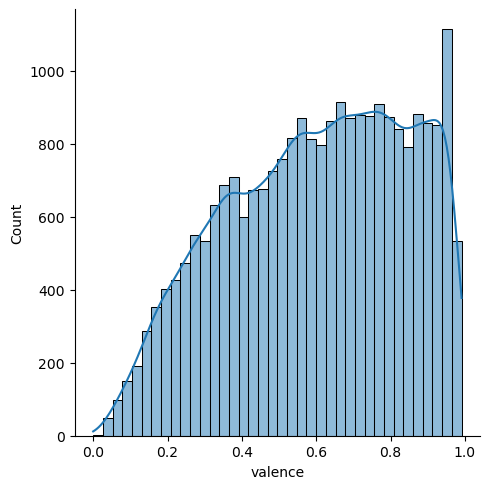

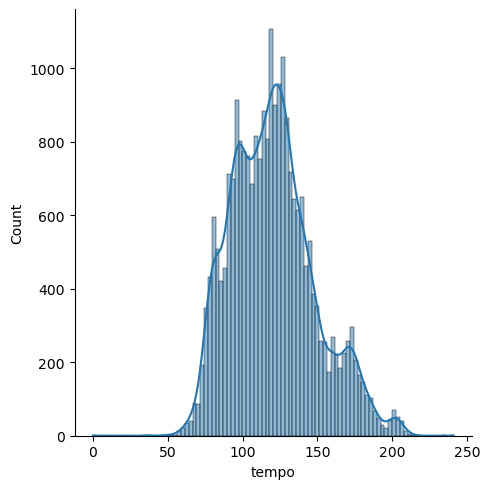

In [10]:
percentage_variables = ["loudness", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence","tempo"]
[sns.displot(audio_feature_df[i], kde=True) for i in percentage_variables]



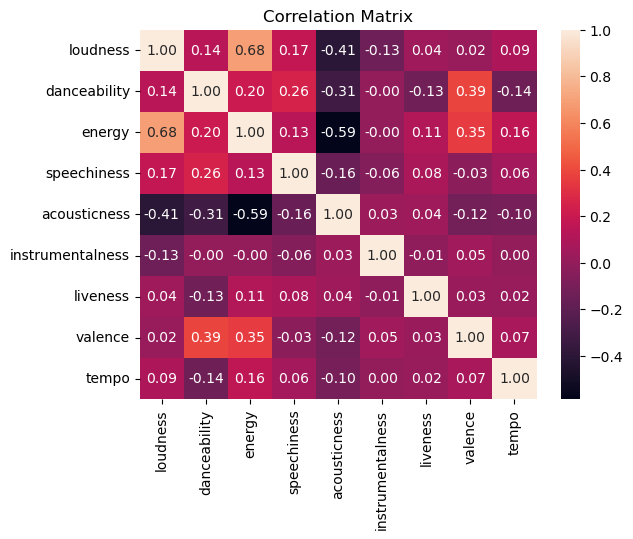

In [11]:
percentage_variables = ["loudness", "danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]

# Calculate the correlation matrix and create a heatmap
corr_matrix = audio_feature_df[percentage_variables].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [12]:
billaboard_df = pd.read_csv('billboard.csv')
billaboard_df.head(5)

#Group the data by artist(s)_name and aggregate the number of songs and total streams
performer_stats = billaboard_df.groupby('performer').agg({'song': 'count', 'weeks_on_chart': 'sum'}).reset_index()
performer_stats.columns = ['performer', 'song', 'weeks_on_chart']

# Calculate the average weeks_on_chart per song for each performer
performer_stats['Avg week on chart per Song'] = (performer_stats['weeks_on_chart'] / performer_stats['song']) / 1e9
billaboard_df['Avg_week_on_chart_per_Song'] = performer_stats['Avg week on chart per Song']

# Sort the data by the number of weeks_on_chart in descending order
performer_stats = performer_stats.sort_values(by='weeks_on_chart', ascending=False)

top_20_artists = performer_stats.head(20)

# Create an interactive bar chart for Total weeks on chart
fig1 = px.bar(top_20_artists, x='performer', y='weeks_on_chart',
              title='Most weeks on chart performer',
              color='performer',
              color_continuous_scale='viridis')

fig1.update_xaxes(categoryorder='total descending')
fig1.update_xaxes(title_text='Performer')
fig1.update_yaxes(title_text='Week on Chart')

# Create an interactive bar chart for Number of Songs
fig2 = px.bar(top_20_artists, x='performer', y='song',
              title='Number of Songs per performer (Top 20)',
              color='performer',
              color_continuous_scale='viridis')

fig2.update_xaxes(categoryorder='total descending')
fig2.update_xaxes(title_text='Performer')
fig2.update_yaxes(title_text='Number of Songs')

# Create an interactive bar chart for Average Streams per Song
fig3 = px.bar(top_20_artists, x='performer', y='Avg week on chart per Song',
              title='Average Streams per Song (Top 20)',
              color='performer',
              color_continuous_scale='viridis')

fig3.update_xaxes(categoryorder='total descending')
fig3.update_xaxes(title_text='Performer')
fig3.update_yaxes(title_text='Average Streams per Song')

fig1.show()
fig2.show()
fig3.show()

C:\Users\bhakt\AppData\Local\Temp\ipykernel_17832\1082898329.py:9: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



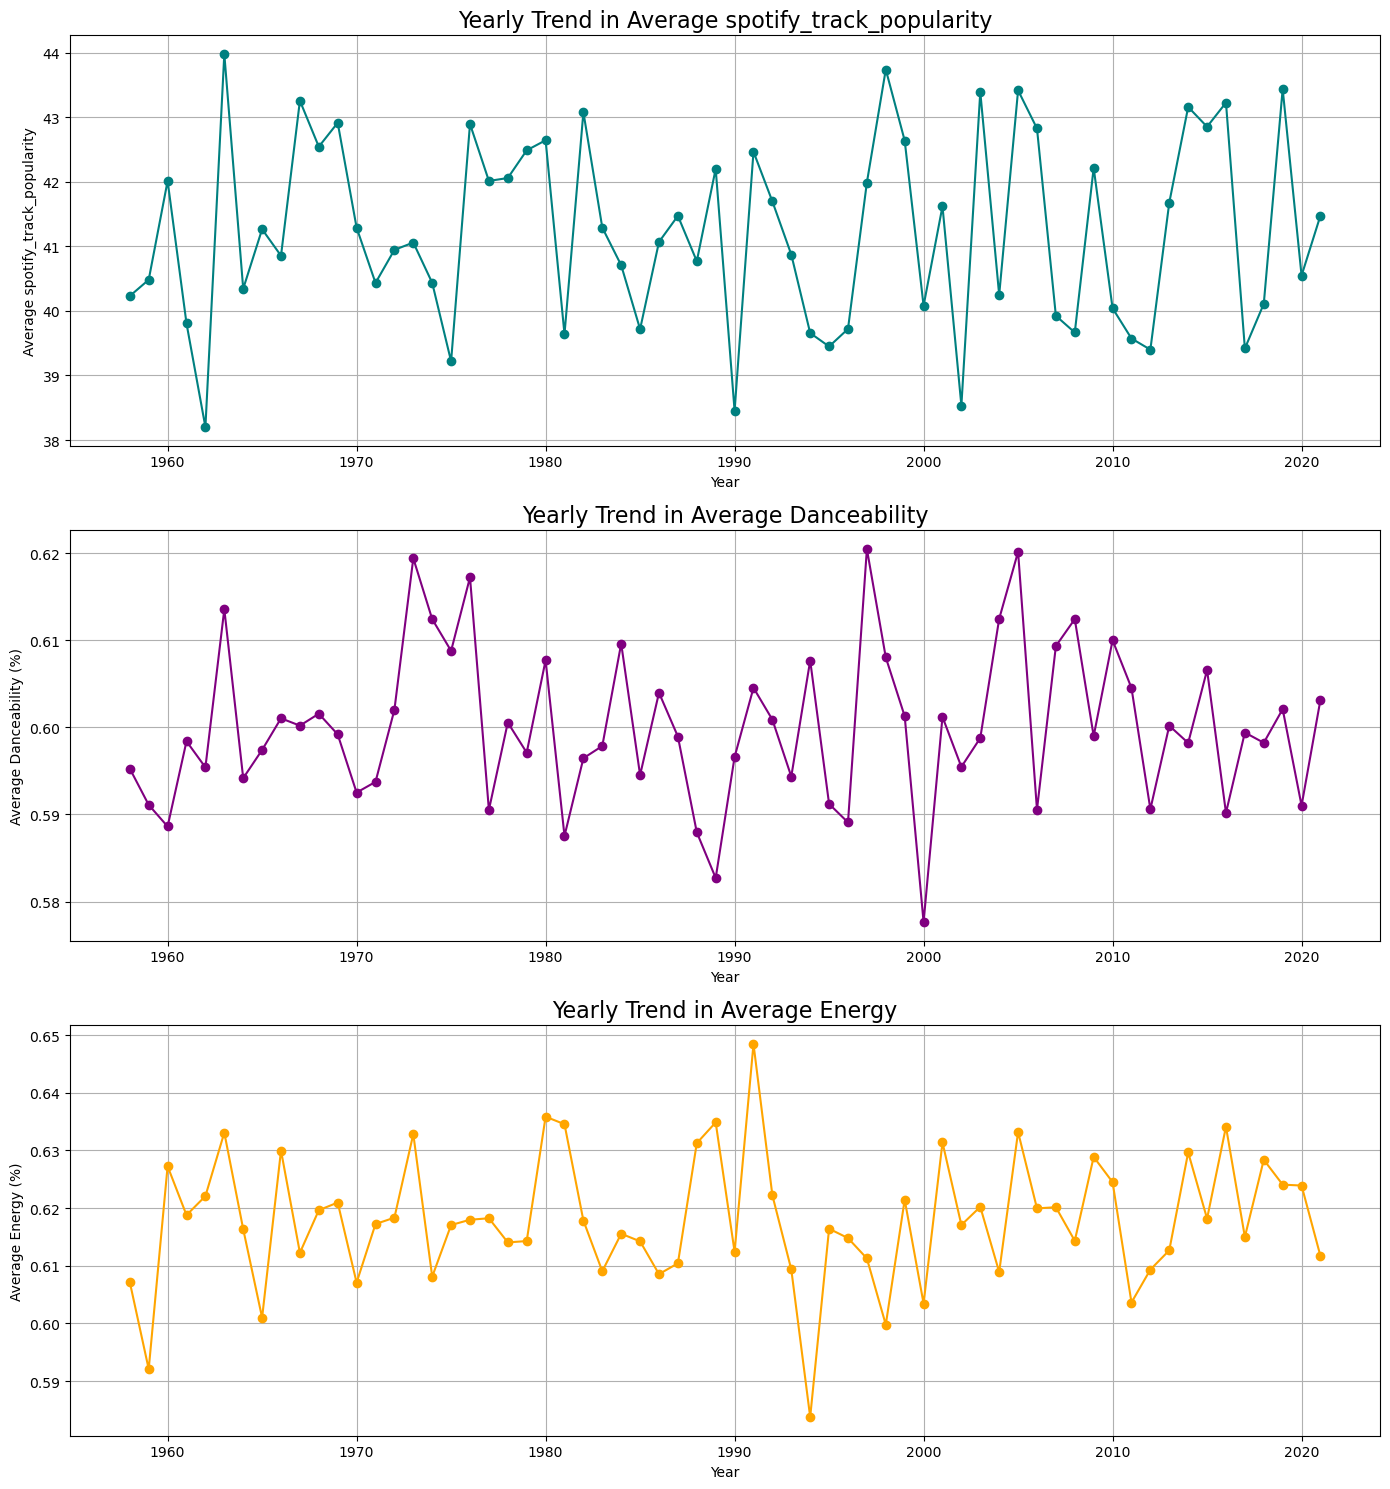

In [13]:
# Calculating yearly averages for songs,spotify_track_popularity, danceability, and energy

cols_to_use = audio_feature_df.columns.difference(billaboard_df.columns)
# Join the two DataFrames on the 'song_id' column
df = pd.merge(billaboard_df, audio_feature_df[cols_to_use], left_index=True, right_index=True, how='inner')
df['week_id'] = pd.to_datetime(df['week_id'])
df['year'] = df['week_id'].dt.year

yearly_averages = df.groupby(df['year'])[['song','spotify_track_popularity', 'danceability', 'energy']].mean()

# Plotting the yearly trends
fig, axes = plt.subplots(nrows=3, figsize=(14, 15))

# Average Streams by Year
axes[0].plot(yearly_averages.index, yearly_averages['spotify_track_popularity'], marker='o', color='teal')
axes[0].set_title('Yearly Trend in Average spotify_track_popularity', fontsize=16)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average spotify_track_popularity')
axes[0].grid(True)

# Average Danceability by Year
axes[1].plot(yearly_averages.index, yearly_averages['danceability'], marker='o', color='purple')
axes[1].set_title('Yearly Trend in Average Danceability', fontsize=16)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Danceability (%)')
axes[1].grid(True)

# Average Energy by Year
axes[2].plot(yearly_averages.index, yearly_averages['energy'], marker='o', color='orange')
axes[2].set_title('Yearly Trend in Average Energy', fontsize=16)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Average Energy (%)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Task 4 Preprocessing

In [14]:
# 1) Data Cleaning

#df is merged dataset
#df.head(5)

#Replacing Missing Data
audio_feature_df.replace("[]", np.nan, inplace = True)
audio_feature_df.head(5)

#replacing nan value
audio_feature_df = audio_feature_df.replace(np.nan, 0)


#Evaluating Missing Data
missing_data = audio_feature_df.isnull()
missing_data.head()
missing_billaboard_df_data = billaboard_df.isnull()
missing_billaboard_df_data.head()


#Count missing values in each column
for column in missing_data.columns.values.tolist(): 
    #print(column)
    print(missing_data[column].value_counts())
for column in missing_billaboard_df_data.columns.values.tolist(): 
    #print(column)
    print(missing_billaboard_df_data[column].value_counts())   


#find dulicate and remove
# Define a function to check for duplicate rows based on the 'spotify_genre' column
def has_duplicates(row):
    if isinstance(row['spotify_genre'], list):  # Check if it's a list
        seen = set()
        for genre in row['spotify_genre']:
            if genre in seen:
                return True
            seen.add(genre)
    return False

# Apply the function to each row and create a boolean mask for duplicates
duplicate_mask = audio_feature_df.apply(has_duplicates, axis=1)


# Filter the DataFrame to remove duplicates
filtered_df = audio_feature_df[~duplicate_mask]




# Check the shape of the filtered DataFrame to verify that duplicates are removed
print(filtered_df.shape)
print(filtered_df.isnull().sum())

filtered_billaboard_df=billaboard_df.copy()

# 2) Data Transformation & Normalization
#Using The maximum absolute scaling
# copy the data 
df_max_scaled = filtered_df.copy() 
  
# Identify numeric columns
numeric_columns = df_max_scaled.select_dtypes(include=['number']).columns

# Apply max scaling only to numeric columns
for column in numeric_columns:
    df_max_scaled[column] = df_max_scaled[column] / df_max_scaled[column].abs().max()

# View the normalized data
display(df_max_scaled)

#Using The z-score method
# copy the data 
df_z_scaled = filtered_billaboard_df.copy() 
# Identify numeric columns
numeric_df_z_scaled = df_z_scaled.select_dtypes(include=['number']).columns
  
# apply normalization techniques 
for column in numeric_df_z_scaled: 
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].mean()) / df_z_scaled[column].std()     
# view normalized data    
display(df_z_scaled)

# Tokenization
def tokenize_text(text):
    # Convert to a string (if it's not already)
    text = str(text)
    # Split by commas and strip whitespace from each token
    tokens = [token.strip() for token in text.split(',')]
    return tokens

# Convert non-text values to empty strings
audio_feature_df['spotify_genre'] = audio_feature_df['spotify_genre'].astype(str).fillna('')
# Apply tokenization to the 'spotify_genre' column
audio_feature_df['tokens'] = audio_feature_df['spotify_genre'].apply(tokenize_text)

# Remove Stop Words
stop_words = set(stopwords.words('english'))
audio_feature_df['filtered_tokens'] = audio_feature_df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])



#3) TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(audio_feature_df['spotify_genre'])
y = audio_feature_df['mode']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model (Logistic Regression in this example)
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Increase max_iter to a higher value
logistic_regression = LogisticRegression(max_iter=1000)


False    29503
Name: song_id, dtype: int64
False    29503
Name: performer, dtype: int64
False    29503
Name: song, dtype: int64
False    29503
Name: spotify_genre, dtype: int64
False    29503
Name: spotify_track_id, dtype: int64
False    29503
Name: spotify_track_preview_url, dtype: int64
False    29503
Name: spotify_track_duration_ms, dtype: int64
False    29503
Name: spotify_track_explicit, dtype: int64
False    29503
Name: spotify_track_album, dtype: int64
False    29503
Name: danceability, dtype: int64
False    29503
Name: energy, dtype: int64
False    29503
Name: key, dtype: int64
False    29503
Name: loudness, dtype: int64
False    29503
Name: mode, dtype: int64
False    29503
Name: speechiness, dtype: int64
False    29503
Name: acousticness, dtype: int64
False    29503
Name: instrumentalness, dtype: int64
False    29503
Name: liveness, dtype: int64
False    29503
Name: valence, dtype: int64
False    29503
Name: tempo, dtype: int64
False    29503
Name: time_signature, dtype: int6

song_id  \
0         -twistin'-White Silver SandsBill Black's Combo   
1      ¿Dònde Està Santa Claus? (Where Is Santa Claus...   
2                 ......And Roses And RosesAndy Williams   
3               ...And Then There Were DrumsSandy Nelson   
4                    ...Baby One More TimeBritney Spears   
...                                                  ...   
29498  Zoo YorkLil Tjay Featuring Fivio Foreign & Pop...   
29499                                         ZoomFuture   
29500                 ZoomLil' Boosie Featuring Yung Joc   
29501     Zorba The GreekHerb Alpert & The Tijuana Brass   
29502                                       Zunga ZengK7   

                                          performer  \
0                                Bill Black's Combo   
1                                        Augie Rios   
2                                     Andy Williams   
3                                      Sandy Nelson   
4                                    Britney Spears   
...                                             ...   
29498  Lil Tjay Featuring Fivio Foreign & Pop Smoke   
29499                                        Future   
29500                Lil' Boosie Featuring Yung Joc   
29501               Herb Alpert & The Tijuana Brass   
29502                                            K7   

                                                   song  \
0                          -twistin'-White Silver Sands   
1      ¿Dònde Està Santa Claus? (Where Is Santa Claus?)   
2                             ......And Roses And Roses   
3                          ...And Then There Were Drums   
4                                 ...Baby One More Time   
...                                                 ...   
29498                                          Zoo York   
29499                                              Zoom   
29500                                              Zoom   
29501                                   Zorba The Greek   
29502                                        Zunga Zeng   

                                           spotify_genre  \
0                                                      0   
1                                            ['novelty']   
2      ['adult standards', 'brill building pop', 'eas...   
3       ['rock-and-roll', 'space age pop', 'surf music']   
4                  ['dance pop', 'pop', 'post-teen pop']   
...                                                  ...   
29498                                                  0   
29499  ['atl hip hop', 'hip hop', 'pop rap', 'rap', '...   
29500          ['baton rouge rap', 'deep southern trap']   
29501    ['adult standards', 'easy listening', 'lounge']   
29502                                      ['freestyle']   

             spotify_track_id  \
0                           0   
1                           0   
2      3tvqPPpXyIgKrm4PR9HCf0   
3      1fHHq3qHU8wpRKHzhojZ4a   
4      3MjUtNVVq3C8Fn0MP3zhXa   
...                       ...   
29498                       0   
29499  2IG6Te7JyvrtqhFeOF7le4   
29500                       0   
29501  3WLEVNohakzZmMpN5W7mHK   
29502  0XevPPcCBPovknaBw3lFvh   

                               spotify_track_preview_url  \
0                                                      0   
1                                                      0   
2      https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...   
3                                                      0   
4      https://p.scdn.co/mp3-preview/da2134a161f1cb34...   
...                                                  ...   
29498                                                  0   
29499  https://p.scdn.co/mp3-preview/cb8fde6edc08e70a...   
29500                                                  0   
29501  https://p.scdn.co/mp3-preview/1841a4034ba42fc0...   
29502  https://p.scdn.co/mp3-preview/8d5174aeb7d6b740...   

       spotify_track_duration_ms spotify_track_explicit  \
0                       0.000000                      0   
1

url     week_id  \
0       http://www.billboard.com/charts/hot-100/1965-0...   7/17/1965   
1       http://www.billboard.com/charts/hot-100/1965-0...   7/24/1965   
2       http://www.billboard.com/charts/hot-100/1965-0...   7/31/1965   
3       http://www.billboard.com/charts/hot-100/1965-0...    8/7/1965   
4       http://www.billboard.com/charts/hot-100/1965-0...   8/14/1965   
...                                                   ...         ...   
327890  https://www.billboard.com/charts/hot-100/2018-...  10/20/2018   
327891  http://www.billboard.com/charts/hot-100/1977-0...   5/21/1977   
327892  http://www.billboard.com/charts/hot-100/1981-0...   5/23/1981   
327893  http://www.billboard.com/charts/hot-100/1973-0...   9/29/1973   
327894  https://www.billboard.com/charts/hot-100/2020-...  11/28/2020   

        week_position                      song                  performer  \
0           -0.571589    Don't Just Stand There                 Patty Duke   
1           -0.987307    Don't Just Stand There                 Patty Duke   
2           -1.264452    Don't Just Stand There                 Patty Duke   
3           -1.403025    Don't Just Stand There                 Patty Duke   
4           -1.472311    Don't Just Stand There                 Patty Duke   
...               ...                       ...                        ...   
327890      -0.987307            God Is A Woman              Ariana Grande   
327891      -0.987307   I Wanna Get Next To You                 Rose Royce   
327892      -0.987307          I Can't Stand It  Eric Clapton And His Band   
327893      -0.987307  Here I Am Come & Take Me                   Al Green   
327894      -0.987307                     Hawai        Maluma & The Weeknd   

                                          song_id  instance  \
0                Don't Just Stand TherePatty Duke -0.217059   
1                Don't Just Stand TherePatty Duke -0.217059   
2                Don't Just Stand TherePatty Duke -0.217059   
3                Don't Just Stand TherePatty Duke -0.217059   
4                Don't Just Stand TherePatty Duke -0.217059   
...                                           ...       ...   
327890                God Is A WomanAriana Grande -0.217059   
327891          I Wanna Get Next To YouRose Royce -0.217059   
327892  I Can't Stand ItEric Clapton And His Band -0.217059   
327893           Here I Am Come & Take MeAl Green -0.217059   
327894                   HawaiMaluma & The Weeknd -0.217059   

        previous_week_position  peak_position  weeks_on_chart  \
0                    -0.092814      -0.249075       -0.678999   
1                    -0.484874      -0.655270       -0.547252   
2                    -0.912576      -0.926066       -0.415504   
3                    -1.197711      -1.061464       -0.283757   
4                    -1.340278      -1.129163       -0.152009   
...                        ...            ...             ...   
327890               -0.948218      -1.129163        0.506728   
327891               -1.340278      -1.061464        0.506728   
327892               -1.268994      -1.061464        0.506728   
327893               -1.126427      -1.061464        0.506728   
327894               -1.268994      -0.993765        0.506728   

        Avg_week_on_chart_per_Song  
0                        -0.331233  
1                        -0.246972  
2                        -1.308656  
3                         0.013587  
4                         1.204270  
...                            ...  
327890                         NaN  
327891                         NaN  
327892                         NaN  
327893                         NaN  
327894                         NaN  

[327895 rows x 11 columns]

Accuracy: 66.07%


C:\Users\bhakt\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# Task 5 – Model Selection, Training, and Optimization

In [15]:
#Logistic Regression 


#billaboard_df.head(5)

billaboard_df.dropna(subset=['previous_week_position', 'peak_position'], inplace=True)

# Assuming 'Week Position' is the target variable
X = billaboard_df[['previous_week_position', 'peak_position']]
y = (billaboard_df['week_position'] == 1).astype(int) 

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Logistic Regression model
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9922451806923583
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58513
           1       0.66      0.66      0.66       676

    accuracy                           0.99     59189
   macro avg       0.83      0.83      0.83     59189
weighted avg       0.99      0.99      0.99     59189



Accuracy: 0.75
Precision: 0.73
Recall: 0.93
F1-Score: 0.82
ROC AUC: 0.71


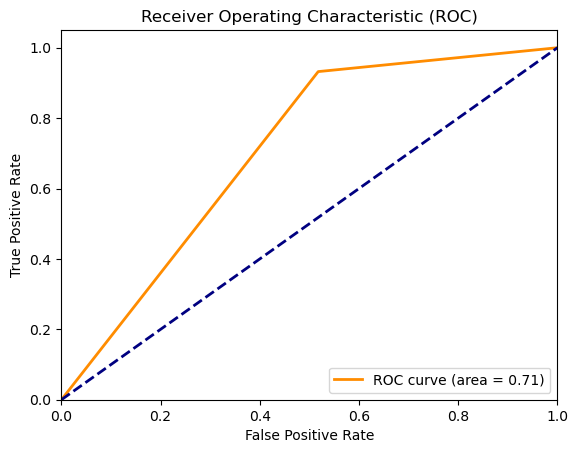

In [16]:


audio_feature_df.dropna(subset=['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness'], inplace=True)
audio_feature_df.dropna(subset=['mode'], inplace=True)

# Define features (X) and target variable (y)
X = audio_feature_df[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness']]
y = audio_feature_df['mode'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

#Evaluate the Model:
# Make predictions on the testing set
y_pred = logistic_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc:.2f}')

# Plot ROC curve (optional)
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [22]:
#Decision Trees for billboard_df Dataset

billaboard_df.dropna(subset=['previous_week_position', 'peak_position'], inplace=True)

# Assuming 'Week Position' is the target variable
X = billaboard_df[['previous_week_position', 'peak_position']]
y = (billaboard_df['week_position'] == 1).astype(int) 

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize and train the Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


print(classification_report(y_test, y_pred))


#Decision Trees for audio_feature_df Dataset
audio_feature_df.dropna(subset=['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness'], inplace=True)
audio_feature_df.dropna(subset=['mode'], inplace=True)

# Define features (X) and target variable (y)
X = audio_feature_df[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness']]
y = audio_feature_df['mode'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = decision_tree_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))



Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58513
           1       0.66      0.66      0.66       676

    accuracy                           0.99     59189
   macro avg       0.83      0.83      0.83     59189
weighted avg       0.99      0.99      0.99     59189

Accuracy: 0.69
              precision    recall  f1-score   support

         0.0       0.62      0.63      0.62      2393
         1.0       0.74      0.74      0.74      3508

    accuracy                           0.69      5901
   macro avg       0.68      0.68      0.68      5901
weighted avg       0.69      0.69      0.69      5901



In [17]:
#SVM for billboard_df Dataset


# Define features (X) and the target variable (y)
X = billaboard_df[['previous_week_position', 'peak_position']]
y = (billaboard_df['week_position'] == 1).astype(int) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM classifier
svm_model = SVC(kernel='linear', random_state=42)  
svm_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

#SVM for audio_feature_df Dataset

audio_feature_df.dropna(subset=['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness'], inplace=True)
audio_feature_df.dropna(subset=['mode'], inplace=True)

# Define features (X) and target variable (y)
X = audio_feature_df[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness']]
y = audio_feature_df['mode'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and train the SVM classifier
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     58513
           1       0.00      0.00      0.00       676

    accuracy                           0.99     59189
   macro avg       0.49      0.50      0.50     59189
weighted avg       0.98      0.99      0.98     59189



C:\Users\bhakt\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\bhakt\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\bhakt\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.77
              precision    recall  f1-score   support

         0.0       0.99      0.44      0.61      2393
         1.0       0.72      1.00      0.84      3508

    accuracy                           0.77      5901
   macro avg       0.86      0.72      0.72      5901
weighted avg       0.83      0.77      0.74      5901



In [18]:
#Neural Network for Classification using billboard_df:
billaboard_df.dropna(subset=['previous_week_position', 'peak_position'], inplace=True)
# Define features (X) and the target variable (y)
X = billaboard_df[['previous_week_position', 'peak_position']]
y = (billaboard_df['week_position'] == 1).astype(int) 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the neural network classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42) 
mlp_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = mlp_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

#Neural Network for Classification using audio_feature_df:
audio_feature_df.dropna(subset=['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness'], inplace=True)
audio_feature_df.dropna(subset=['mode'], inplace=True)

# Define features (X) and target variable (y)
X = audio_feature_df[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness']]
y = audio_feature_df['mode'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the neural network classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42) 
mlp_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = mlp_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))


Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58513
           1       0.66      0.66      0.66       676

    accuracy                           0.99     59189
   macro avg       0.83      0.83      0.83     59189
weighted avg       0.99      0.99      0.99     59189

Accuracy: 0.77
              precision    recall  f1-score   support

         0.0       0.98      0.44      0.61      2393
         1.0       0.72      0.99      0.84      3508

    accuracy                           0.77      5901
   macro avg       0.85      0.72      0.72      5901
weighted avg       0.83      0.77      0.75      5901



In [19]:
#k-Nearest Neighbors (k-NN) for billboard_df Dataset:

billaboard_df.dropna(subset=['previous_week_position', 'peak_position'], inplace=True)
# Define features (X) and the target variable (y)
X = billaboard_df[['previous_week_position', 'peak_position']]
y = (billaboard_df['week_position'] == 1).astype(int) 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the k-NN classifier (you can choose the number of neighbors)
knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

#k-Nearest Neighbors (k-NN) for audio_feature_df Dataset:

audio_feature_df.dropna(subset=['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness'], inplace=True)
audio_feature_df.dropna(subset=['mode'], inplace=True)

# Define features (X) and target variable (y)
X = audio_feature_df[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness']]
y = audio_feature_df['mode'] 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the k-NN classifier (you can choose the number of neighbors)
knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = knn_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     58513
           1       0.56      0.85      0.68       676

    accuracy                           0.99     59189
   macro avg       0.78      0.92      0.84     59189
weighted avg       0.99      0.99      0.99     59189

Accuracy: 0.74
              precision    recall  f1-score   support

         0.0       0.74      0.55      0.63      2393
         1.0       0.74      0.87      0.80      3508

    accuracy                           0.74      5901
   macro avg       0.74      0.71      0.72      5901
weighted avg       0.74      0.74      0.73      5901



In [23]:
#vanilla approach report for all machine learning models

# Evaluate the Vanilla Models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

accuracy_logistic, report_logistic = evaluate_model(logistic_model, X_test, y_test)
decision_tree_model, report_decision_tree = evaluate_model(decision_tree_model, X_test, y_test)
accuracy_svm, report_svm = evaluate_model(svm_model, X_test, y_test)
mlp_classifier, report_mlp_classifier = evaluate_model(mlp_classifier, X_test, y_test)
accuracy_knn, report_knn = evaluate_model(knn_model, X_test, y_test)



print("Logistic Regression (Vanilla):")
print(f"Accuracy: {accuracy_logistic:.2f}")
print(report_logistic)

print("Decision Tree (Vanilla):")
print(f"Accuracy: {decision_tree_model:.2f}")
print(report_decision_tree)

print("\nSupport Vector Machine (SVM) (Vanilla):")
print(f"Accuracy: {accuracy_svm:.2f}")
print(report_svm)

print("\nNeural Network (Vanilla):")
print(f"Accuracy: {mlp_classifier:.2f}")
print(report_mlp_classifier)

print("\nk-Nearest Neighbors (k-NN) (Vanilla):")
print(f"Accuracy: {accuracy_knn:.2f}")
print(report_knn)





Logistic Regression (Vanilla):
Accuracy: 0.75
              precision    recall  f1-score   support

         0.0       0.83      0.48      0.61      2393
         1.0       0.73      0.93      0.82      3508

    accuracy                           0.75      5901
   macro avg       0.78      0.71      0.71      5901
weighted avg       0.77      0.75      0.73      5901

Decision Tree (Vanilla):
Accuracy: 0.69
              precision    recall  f1-score   support

         0.0       0.62      0.63      0.62      2393
         1.0       0.74      0.74      0.74      3508

    accuracy                           0.69      5901
   macro avg       0.68      0.68      0.68      5901
weighted avg       0.69      0.69      0.69      5901


Support Vector Machine (SVM) (Vanilla):
Accuracy: 0.77
              precision    recall  f1-score   support

         0.0       0.99      0.44      0.61      2393
         1.0       0.72      1.00      0.84      3508

    accuracy                           0

In [25]:
#performance improvement techniques

#k-fold cross-validation

# Example of Cross-Validation for the Logistic Regression model
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

# Initialize and train the logistic regression model
logistic_model = LogisticRegression()
cv_scores_logistic = cross_val_score(logistic_model, X, y, cv=kf, scoring='accuracy')

# Initialize and train the Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
cv_scores_decision = cross_val_score(decision_tree_model, X, y, cv=kf, scoring='accuracy')

# Initialize and train the SVM classifier
svm_model = SVC(kernel='linear', random_state=42)
cv_scores_SVM = cross_val_score(svm_model, X, y, cv=kf, scoring='accuracy')

# Initialize and train the neural network classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), random_state=42) 
cv_scores_NLP = cross_val_score(mlp_classifier, X, y, cv=kf, scoring='accuracy')

# Initialize and train the k-NN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)
cv_scores_KNN = cross_val_score(knn_model, X, y, cv=kf, scoring='accuracy')


# Display cross-validation results
print("Cross-Validation Scores for Logistic Regression:")
print(cv_scores_logistic)
print(f"Mean Accuracy: {cv_scores_logistic.mean():.2f}")

print("Cross-Validation Scores for Decision Tree:")
print(cv_scores_decision)
print(f"Mean Accuracy: {cv_scores_decision.mean():.2f}")

print("Cross-Validation Scores for SVM Model :")
print(cv_scores_SVM)
print(f"Mean Accuracy: {cv_scores_SVM.mean():.2f}")

print("Cross-Validation Scores for NLP Model:")
print(cv_scores_NLP)
print(f"Mean Accuracy: {cv_scores_NLP.mean():.2f}")

print("Cross-Validation Scores for k-Nearest Neighbors:")
print(cv_scores_KNN)
print(f"Mean Accuracy: {cv_scores_KNN.mean():.2f}")





Cross-Validation Scores for Logistic Regression:
[0.74970344 0.75156753 0.76071852 0.7520339  0.75254237]
Mean Accuracy: 0.75
Cross-Validation Scores for Decision Tree:
[0.69361125 0.68734113 0.69310286 0.68728814 0.68288136]
Mean Accuracy: 0.69
Cross-Validation Scores for SVM Model :
[0.76970005 0.77071683 0.77918997 0.77677966 0.77372881]
Mean Accuracy: 0.77
Cross-Validation Scores for NLP Model:
[0.76970005 0.77122522 0.77986782 0.77711864 0.77542373]
Mean Accuracy: 0.77
Cross-Validation Scores for k-Nearest Neighbors:
[0.74004406 0.73784104 0.74817827 0.74169492 0.73864407]
Mean Accuracy: 0.74


In [26]:
# Initialize the logistic regression model
logistic_model = LogisticRegression()

# Initialize and train the Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(random_state=42)


# Define hyperparameters and their possible values for Logistic Regression
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
}

# Define hyperparameters and their possible values for Decision Tree
param_grid_DT = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    
}



# Initialize GridSearchCV
grid_search_LR = GridSearchCV(logistic_model, param_grid_LR, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_DT = GridSearchCV(decision_tree_model, param_grid_DT, cv=5, scoring='accuracy', n_jobs=-1)


# Fit the models to find the best hyperparameters
grid_search_LR.fit(X_train, y_train)
grid_search_DT.fit(X_train, y_train)

# Display the best hyperparameters
best_params_LR = grid_search_LR.best_params_
print("Best Hyperparameters for Logistic Regression:")
print(best_params_LR)

best_params_DT = grid_search_DT.best_params_
print("Best Hyperparameters for Decision Tree:")
print(best_params_DT)

best_accuracy_LR, best_report_LR = evaluate_model(grid_search_LR, X_test, y_test)
print("\nLogistic Regression (Tuned Hyperparameters):")
print(f"Accuracy: {best_accuracy_LR:.2f}")
print(best_report_LR)

best_accuracy_DT, best_report_DT = evaluate_model(grid_search_DT, X_test, y_test)
print("\nDecision Tree (Tuned Hyperparameters):")
print(f"Accuracy: {best_accuracy_DT:.2f}")
print(best_report_DT)



C:\Users\bhakt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\bhakt\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\bhakt\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bhakt\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver =

Best Hyperparameters for Logistic Regression:
{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best Hyperparameters for Decision Tree:
{'criterion': 'entropy', 'max_depth': 5}

Logistic Regression (Tuned Hyperparameters):
Accuracy: 0.77
              precision    recall  f1-score   support

         0.0       1.00      0.43      0.61      2393
         1.0       0.72      1.00      0.84      3508

    accuracy                           0.77      5901
   macro avg       0.86      0.72      0.72      5901
weighted avg       0.83      0.77      0.74      5901


Decision Tree (Tuned Hyperparameters):
Accuracy: 0.77
              precision    recall  f1-score   support

         0.0       1.00      0.43      0.61      2393
         1.0       0.72      1.00      0.84      3508

    accuracy                           0.77      5901
   macro avg       0.86      0.72      0.72      5901
weighted avg       0.83      0.77      0.74      5901



In [27]:
# Assuming you have features X and labels y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize the SVM classifier
svm_model = SVC(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters for SVM Model:")
print(best_params)

# Use the best model for predictions
best_svm_model = grid_search.best_estimator_
y_pred = best_svm_model.predict(X_test)

# Evaluate the best model
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(report)


Best Hyperparameters for SVM Model:
{'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.77
              precision    recall  f1-score   support

         0.0       1.00      0.43      0.61      2393
         1.0       0.72      1.00      0.84      3508

    accuracy                           0.77      5901
   macro avg       0.86      0.72      0.72      5901
weighted avg       0.83      0.77      0.74      5901



In [28]:
# Initialize and train the neural network classifier
mlp_classifier = MLPClassifier(random_state=42) 

param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (32, 16)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}
grid_search_NLP = GridSearchCV(mlp_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_NLP.fit(X_train, y_train)

best_params_NLP = grid_search_NLP.best_params_
print("Best Hyperparameters for NLP:")
print(best_params_NLP)

best_accuracy_NLP, best_report_NLP = evaluate_model(grid_search_NLP, X_test, y_test)
print("\nNLP (Tuned Hyperparameters):")
print(f"Accuracy: {best_accuracy_NLP:.2f}")
print(best_report_NLP)


Best Hyperparameters for NLP:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (32, 16), 'learning_rate': 'constant'}

NLP (Tuned Hyperparameters):
Accuracy: 0.77
              precision    recall  f1-score   support

         0.0       1.00      0.44      0.61      2393
         1.0       0.72      1.00      0.84      3508

    accuracy                           0.77      5901
   macro avg       0.86      0.72      0.72      5901
weighted avg       0.83      0.77      0.74      5901



In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Initialize and train the k-NN classifier
knn_model = KNeighborsClassifier(n_neighbors=5)

# Define hyperparameters and their possible values for KNN
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  
}

# Initialize GridSearchCV
grid_search_KNN = GridSearchCV(knn_model, param_grid_KNN, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to find the best hyperparameters
grid_search_KNN.fit(X_train, y_train)

# Display the best hyperparameters
best_params_KNN = grid_search_KNN.best_params_
print("Best Hyperparameters for KNN:")
print(best_params_KNN)

# Evaluate the model with the best hyperparameters
best_accuracy_KNN, best_report_KNN = evaluate_model(grid_search_KNN, X_test, y_test)
print("\nKNN (Tuned Hyperparameters):")
print(f"Accuracy: {best_accuracy_KNN:.2f}")
print(best_report_KNN)


Best Hyperparameters for KNN:
{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}

KNN (Tuned Hyperparameters):
Accuracy: 0.75
              precision    recall  f1-score   support

         0.0       0.79      0.53      0.64      2393
         1.0       0.74      0.91      0.81      3508

    accuracy                           0.75      5901
   macro avg       0.77      0.72      0.72      5901
weighted avg       0.76      0.75      0.74      5901



In [31]:
logistic_model = LogisticRegression()
decision_tree_model = DecisionTreeClassifier(random_state=42)
svm_model = SVC(random_state=42)
mlp_classifier = MLPClassifier(random_state=42) 
knn_model = KNeighborsClassifier(n_neighbors=5)

logistic_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
mlp_classifier.fit(X_train, y_train)
knn_model.fit(X_train, y_train)

# Assuming you have trained and predicted with your models: model1, model2, model3
y_pred1 = logistic_model.predict(X_test)
y_pred2 = decision_tree_model.predict(X_test)
y_pred3 = svm_model.predict(X_test)
y_pred4 = mlp_classifier.predict(X_test)
y_pred5 = knn_model.predict(X_test) 


# Calculate metrics for each model
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1)
recall1 = recall_score(y_test, y_pred1)
f1_score1 = f1_score(y_test, y_pred1)

 

accuracy2 = accuracy_score(y_test, y_pred2)
precision2 = precision_score(y_test, y_pred2)
recall2 = recall_score(y_test, y_pred2)
f1_score2 = f1_score(y_test, y_pred2)

 

accuracy3 = accuracy_score(y_test, y_pred3)
precision3 = precision_score(y_test, y_pred3)
recall3 = recall_score(y_test, y_pred3)
f1_score3 = f1_score(y_test, y_pred3)

 
accuracy4 = accuracy_score(y_test, y_pred4)
precision4 = precision_score(y_test, y_pred4)
recall4 = recall_score(y_test, y_pred4)
f1_score4 = f1_score(y_test, y_pred4)


accuracy5 = accuracy_score(y_test, y_pred5)
precision5 = precision_score(y_test, y_pred5)
recall5 = recall_score(y_test, y_pred5)
f1_score5 = f1_score(y_test, y_pred5)




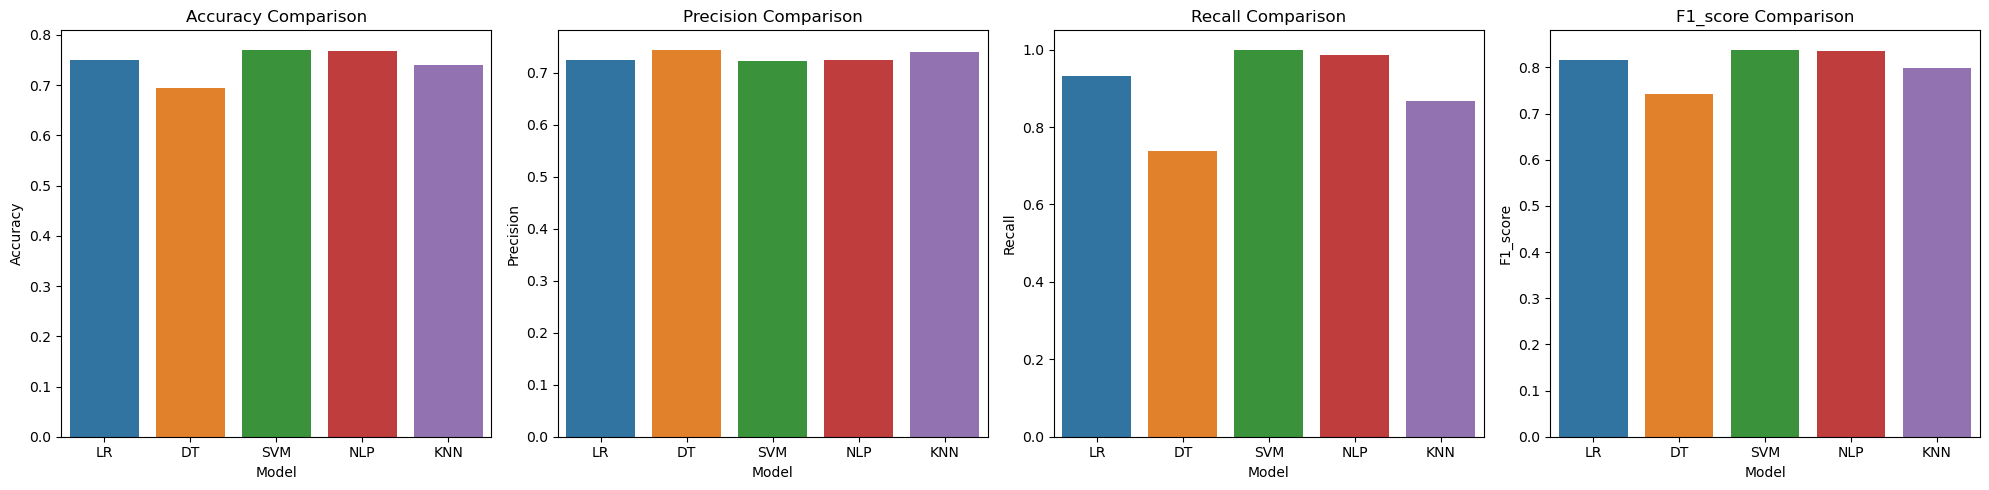

In [37]:
#Comparison of Model 
# Assuming you have calculated accuracy, precision, and recall for multiple models
# Create a DataFrame to store the results
data = {
    'Model': ['LR', 'DT', 'SVM', 'NLP','KNN'], 
    'Accuracy': [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5],
    'Precision': [precision1, precision2, precision3, precision4, precision5],
    'Recall': [recall1, recall2, recall3, recall4, recall5],
    'F1_score': [f1_score1, f1_score2, f1_score3, f1_score4, f1_score5]
}



results_df = pd.DataFrame(data)

 

# Create subplots for Accuracy, Precision, and Recall
#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5)) 
 

# Plot Accuracy
sns.barplot(x='Model', y='Accuracy', data=results_df, ax=axes[0])
axes[0].set_title('Accuracy Comparison')

 

# Plot Precision
sns.barplot(x='Model', y='Precision', data=results_df, ax=axes[1])
axes[1].set_title('Precision Comparison')

 

# Plot Recall
sns.barplot(x='Model', y='Recall', data=results_df, ax=axes[2])
axes[2].set_title('Recall Comparison')

# Plot F1_score
sns.barplot(x='Model', y='F1_score', data=results_df, ax=axes[3])
axes[3].set_title('F1_score Comparison')
 

plt.tight_layout()
plt.show()



In [33]:


#Decision Trees for billboard_df Dataset

billaboard_df.dropna(subset=['previous_week_position', 'peak_position'], inplace=True)

# Assuming 'Week Position' is the target variable
X_preprocess = billaboard_df[['previous_week_position', 'peak_position']]
y_preprocess = (billaboard_df['week_position'] == 1).astype(int)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_preprocess, X_test_preprocess, y_train_preprocess, y_test_preprocess = train_test_split(X_preprocess, y_preprocess, test_size=0.2, random_state=40)


# Initialize and train the Decision Tree classifier
decision_tree_model_preprocess = DecisionTreeClassifier(random_state=40)
decision_tree_model_preprocess.fit(X_train_preprocess, y_train_preprocess)

# Make predictions on the testing set
y_pred_preprocess = decision_tree_model_preprocess.predict(X_test_preprocess)

# Evaluate the model
accuracy_DT_PreProcess = accuracy_score(y_test_preprocess, y_pred_preprocess)
print(f'Accuracy Preprocess: {accuracy_DT_PreProcess:.2f}')


print(classification_report(y_test_preprocess, y_pred_preprocess))


#Decision Trees for audio_feature_df Dataset
audio_feature_df.dropna(subset=['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness'], inplace=True)
audio_feature_df.dropna(subset=['mode'], inplace=True)

# Define features (X) and target variable (y)
X_preprocess = audio_feature_df[['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness']]
y_preprocess = audio_feature_df['mode'] 

# Split data into training and testing sets
X_train_preprocess, X_test_preprocess, y_train_preprocess, y_test_preprocess = train_test_split(X_preprocess, y_preprocess, test_size=0.2, random_state=40)

# Initialize and train the Decision Tree classifier
decision_tree_model_preprocess_AF = DecisionTreeClassifier(random_state=42)
decision_tree_model_preprocess_AF.fit(X_train_preprocess, y_train_preprocess)

# Make predictions on the testing set
y_pred_preprocess = decision_tree_model_preprocess_AF.predict(X_test_preprocess)

# Evaluate the model
accuracy_af_DT_PreProcess = accuracy_score(y_test, y_pred_preprocess)
print(f'Accuracy: {accuracy_af_DT_PreProcess:.2f}')

print(classification_report(y_test_preprocess, y_pred_preprocess))

# Calculate metrics for preprocess DT
accuracy_PreProcess = accuracy_score(y_test_preprocess, y_pred_preprocess)
precision_PreProcess = precision_score(y_test_preprocess, y_pred_preprocess)
recall_PreProcess = recall_score(y_test_preprocess, y_pred_preprocess)
f1_score_PreProcess = f1_score(y_test_preprocess, y_pred_preprocess)

Accuracy Preprocess: 0.99
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58512
           1       0.65      0.63      0.64       677

    accuracy                           0.99     59189
   macro avg       0.83      0.81      0.82     59189
weighted avg       0.99      0.99      0.99     59189

Accuracy: 0.52
              precision    recall  f1-score   support

         0.0       0.60      0.65      0.62      2303
         1.0       0.76      0.73      0.74      3598

    accuracy                           0.70      5901
   macro avg       0.68      0.69      0.68      5901
weighted avg       0.70      0.70      0.70      5901



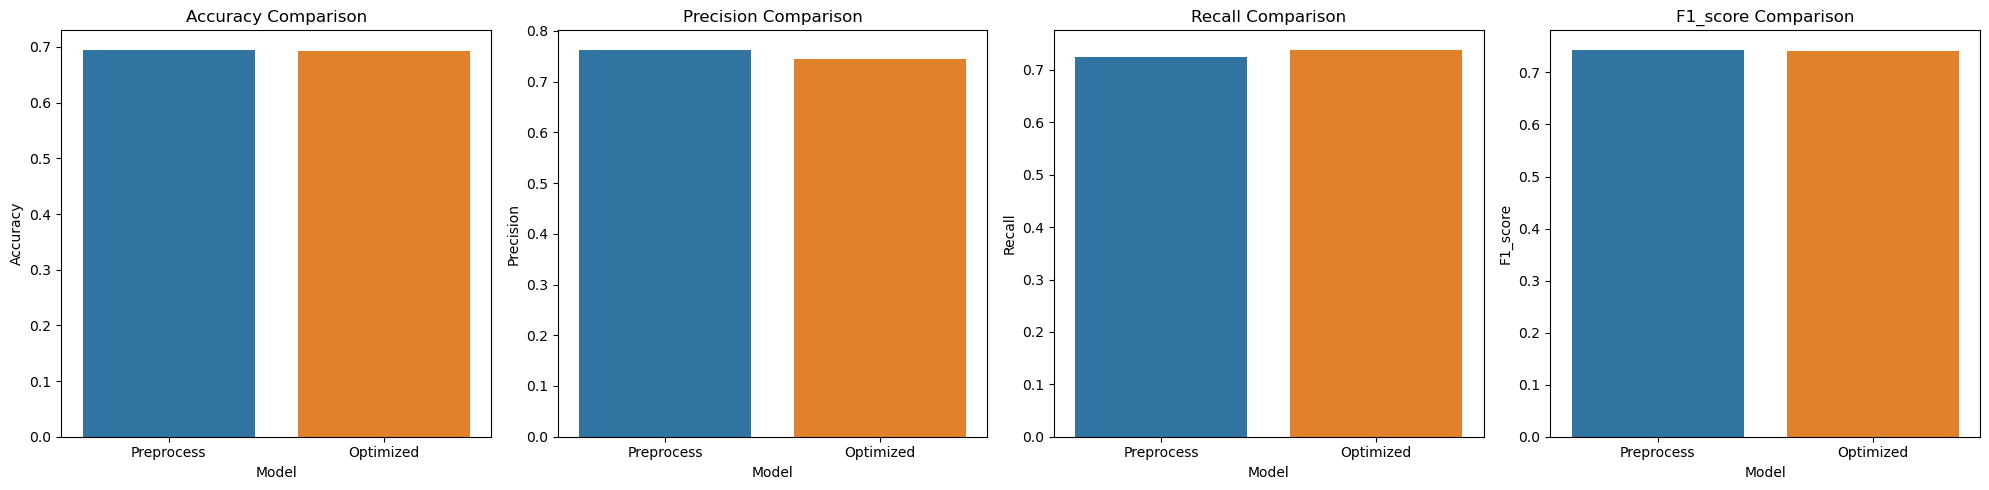

In [36]:
#Comparison of Decision Tree Model with PreProcess and Optimized model

# Create a DataFrame to store the results
data = {
    'Model': ['Preprocess', 'Optimized'], 
    'Accuracy': [accuracy_PreProcess, accuracy2],
    'Precision': [precision_PreProcess, precision2],
    'Recall': [recall_PreProcess, recall2],
    'F1_score': [f1_score_PreProcess, f1_score2]
}



results_df = pd.DataFrame(data)

 

# Create subplots for Accuracy, Precision, and Recall
#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5)) 
 

# Plot Accuracy
sns.barplot(x='Model', y='Accuracy', data=results_df, ax=axes[0])
axes[0].set_title('Accuracy Comparison')

 

# Plot Precision
sns.barplot(x='Model', y='Precision', data=results_df, ax=axes[1])
axes[1].set_title('Precision Comparison')

 

# Plot Recall
sns.barplot(x='Model', y='Recall', data=results_df, ax=axes[2])
axes[2].set_title('Recall Comparison')

# Plot F1_score
sns.barplot(x='Model', y='F1_score', data=results_df, ax=axes[3])
axes[3].set_title('F1_score Comparison')
 

plt.tight_layout()
plt.show()